In [2]:
from _bootstrap import PROJECT_ROOT, RESULTS_DIR, FIGURES_DIR, DEFAULT_SEEDS
from src.config import SimConfig, MetricsConfig


SIM = SimConfig(
    N=300,
    steps=1500,
    save_every=30,
    attraction=0.0,      
    noise=0.03,
    interaction_range=0.30,
)

MET = MetricsConfig(
    eps=0.06,              #
    bins=20,
    min_size=3,
    burn_frac=0.6,
)

[bootstrap] PROJECT_ROOT = /Users/tonyvo/Desktop/project_comp_sci
[bootstrap] RESULTS_DIR  = /Users/tonyvo/Desktop/project_comp_sci/results
[bootstrap] FIGURES_DIR  = /Users/tonyvo/Desktop/project_comp_sci/figures


In [3]:
import numpy as np
import matplotlib.pyplot as plt

from src.flocking_sim_3d import run_simulation

box_size = 1.0
eps = 0.05
steps = 400
N = 200
align=1.0
cohesion=0.5           
noise=0.05
R=0.15
speed=0.03
repulsion_radius=0.05
repulsion_strength=1.0


This notebook runs 3d flocking simulations to match the data generated in the paper. 

Firstly, we will run simulations on the density of the flock. 

In [4]:
def flock_volume_from_pca(pos, box_size=None):
    """
    Approximates flock volume using principal dimensions (ellipsoid).
    """
    
    X = pos.copy()

    # adjust for periodic boundary conditions
    if box_size is not None:
        # unwrap relative to center of mass (com)
        com = X.mean(axis=0)
        rel = X - com
        rel -= box_size * np.round(rel / box_size)
        X = com + rel

    # center flock position around the origin
    Xc = X - X.mean(axis=0)

    # compute covariance matrix describing flock spatial spread - result in a 3x3 matrix
    C = (Xc.T @ Xc) / Xc.shape[0]

    #PCA Eigendecomposition to get new axes
    evals, _ = np.linalg.eigh(C)
    evals = np.sort(evals)[::-1]

    # principal spatial dimensions (length, width, thickness)
    I3, I2, I1 = np.sqrt(np.maximum(evals, 0))

    # approximate flock volume using equivalent ellipsoid
    V = (4/3) * np.pi * I1 * I2 * I3

    return V, (I1, I2, I3)


def flock_density(pos, box_size=None):
    N = pos.shape[0]          # number of birds
    V, _ = flock_volume_from_pca(pos, box_size)
    density = N / V
    return density




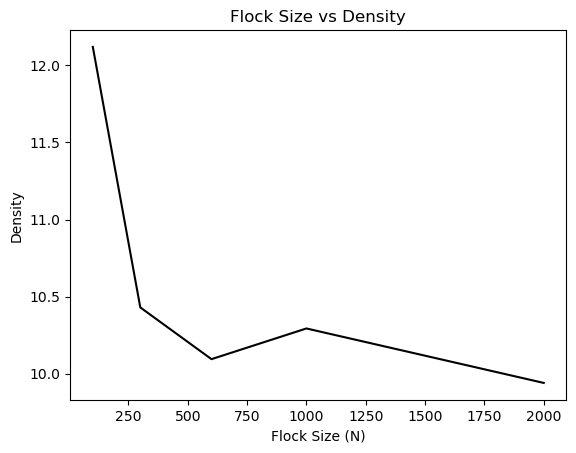

In [5]:
N = [100, 300, 600, 1000, 2000]

densities = []

for n in N:
    # We have to scale the box size, interaction, and repulsion radius as N gets bigger to get real proportional density measures,
    box_size = n**(1/3)
    R = 0.2 * box_size
    repulsion_radius = 0.1 * box_size

    position = run_simulation(
            N=n,
            steps=steps,
            box_size=box_size,
            align=align,
            cohesion=cohesion,               
            noise=noise,
            R=R,
            speed=speed,
            repulsion_radius=repulsion_radius,
            repulsion_strength=repulsion_strength,
            
            use_predator=False,
            predator_strength=5.0,         
            #defaults to 3*R
            predator_radius=None,
            #defaults to 1 * speed 
            predator_speed=None,           
            
            dt=0.1,
            seed=None,
            save_every=1,
            softening=1e-6,
        )
    densities.append(
    flock_density(position[-1], box_size=box_size)
)

plt.figure()
plt.plot(N, densities, 'k-')
plt.xlabel("Flock Size (N)")
plt.ylabel("Density")
plt.title("Flock Size vs Density")
plt.savefig("../figures/flock_density_N.png", dpi=200)
plt.show()

After correcting for container effects by scaling system size with flock size, the simulation exhibits approximately size-independent density, consistent with empirical measurements of starling flocks.

In [6]:
from scipy.spatial import ConvexHull

def pca_axes(pos):
    X = pos - pos.mean(axis=0)
    C = (X.T @ X) / X.shape[0]
    evals, _ = np.linalg.eigh(C)
    evals = np.sort(evals)[::-1]  # largest -> smallest
    # Axis-length proxies (proportional to std dev along axes)
    I3, I2, I1 = np.sqrt(np.maximum(evals, 0))
    return I1, I2, I3

def hull_volume(pos):
    # Convex hull volume proxy
    hull = ConvexHull(pos)
    return hull.volume

In [ ]:
Ns = [100, 300, 600, 1000, 2000]
results = []

for n in Ns:
    box_size = n**(1/3)  # your scaling fix

    history = run_simulation(
        N=n,
        box_size=box_size,
        R=0.2 * box_size,
        repulsion_radius=0.1 * box_size,
        cohesion=0.2,
        repulsion_strength=2.0,
        align=1.0,
        noise=0.1,
        steps=600,
        seed=42
    )

    pos = history[-1]
    V = hull_volume(pos)
    I1, I2, I3 = pca_axes(pos)

    results.append({
        "N": n,
        "V": V,
        "V13": V**(1/3),
        "I1": I1,
        "I2I1": (I2 / (I1 + 1e-12)),
        "I3I1": (I3 / (I1 + 1e-12)),
    })


In [ ]:
V13 = [r["V13"] for r in results]
I1  = [r["I1"]  for r in results]
I2I1 = [r["I2I1"] for r in results]
I3I1 = [r["I3I1"] for r in results]

plt.figure()
plt.plot(V13, I1, marker="o")
plt.xlabel("V^(1/3)")
plt.ylabel("Thickness I1 (PCA proxy)")
plt.title("Thickness vs V^(1/3)")
plt.show()

plt.figure()
plt.plot(Ns, I2I1, marker="o", label="I2/I1")
plt.plot(Ns, I3I1, marker="o", label="I3/I1")
plt.xlabel("N")
plt.ylabel("Aspect ratio")
plt.title("Aspect ratios vs N")
plt.legend()
plt.show()
